In [1]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


sys.path.append('../')

from utils import utils, model_fetch, dataloader
metrics_dict = {}

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
# Which model to evaluate


####### Change This #######
model_of_interest = "cutmix"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "true_baseline": base_path + 'lenet_baseline_lr=1e-4_1587335542/model_best.pth.tar',
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "augmented": base_path + '',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
}

model = model_fetch.fetch_student('lenet')
_, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_of_interest])
model.eval()

=> Loading Checkpoint '../distillation_experiments/runs/student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar' (epoch 250)
Current Loss :  1.088435726829722


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
# Loading both test sets - CIFAR and CIFAR - 10H -- Images are same.

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# CIFAR-10H data
data_prob = np.load('../data/cifar-10h/cifar10h-probs.npy')
data_counts = np.load('../data/cifar-10h/cifar10h-counts.npy')

# CIFAR Data
file_path = '../data/data-cifar-10/cifar-10-batches-py/test_batch'
label_dict = unpickle(file_path)

# Labels for both data
human_labels = data_prob.argmax(axis=1)
cifar_labels = label_dict[b'labels'] 

# print(label_dict.keys())

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

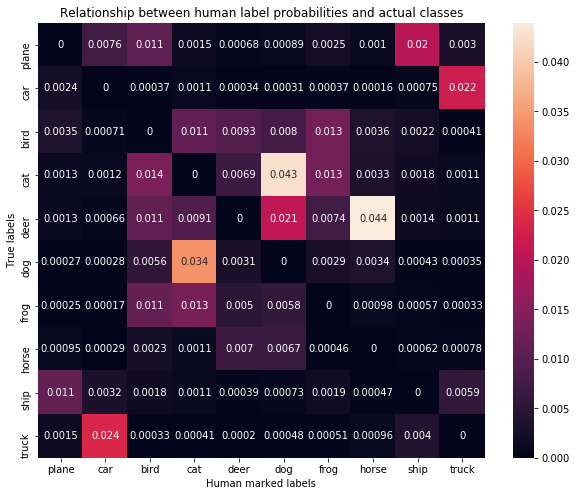

In [32]:
# Create conf-matrix like proba-distribution visualization for human labels
# Ground each human proba for an image on the ground truth and find the distribution for each GT class(rows)

human_conf = np.zeros((10,10))
for i, prob in enumerate(data_prob):
    gt_label = cifar_labels[i]
    human_conf[gt_label] += prob
    
human_counts = np.unique(human_labels, return_counts=True)
for i, count in enumerate(human_counts[1]):
    human_conf[i] /= count
    
# Diagonal elements set to zero so that other correlations are enhanced
human_conf2 = np.zeros((10,10))
for i in range(len(human_conf)):
    for j in range(len(human_conf[0])):
        if i != j:
            human_conf2[i][j] = human_conf[i][j]
        

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot()
sns.heatmap(human_conf2, annot=True, ax = ax); #annot=True to annotate cells  

ax.set_xlabel('Human marked labels')
ax.set_ylabel('True labels')
ax.set_title('Relationship between human label probabilities and actual classes')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

In [33]:
# Create PyTorch dataset for CIFAR images

data = label_dict[b'data'].reshape((10000, 3, 32, 32))
data = data.transpose((0,2,3,1))
dataset = dataloader.MyDataset(data, cifar_labels)

In [34]:
# Create softmax preds from model using above dataset

preds = []
for i in tqdm(range(len(dataset))):
    img, label = dataset[i]
    img = img.unsqueeze(0)
    softmax = torch.nn.Softmax(dim=1)
    pred = softmax(model(img))
    preds.append(pred.detach().numpy())
#     break
preds = np.array(preds).squeeze(axis=1)
preds.shape

100%|██████████| 10000/10000 [00:06<00:00, 1600.11it/s]


(10000, 10)

In [35]:
# Update existing Metrics Dictionary for CIFAR classification

metrics = utils.find_metrics(preds, np.array(cifar_labels), False)
metrics_df = metrics_dict.update({model_of_interest:
    {
        "accuracy": metrics[0],
        "precision": metrics[1],
        "recall": metrics[2],
        "f1-score": metrics[3]
    }})

pd.DataFrame(metrics_dict)

,cutmix,mixup,baseline
accuracy,0.621300,0.633500,0.652000
precision,0.617724,0.630683,0.648755
recall,0.621300,0.633500,0.652000
f1-score,0.619058,0.631768,0.650052


[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

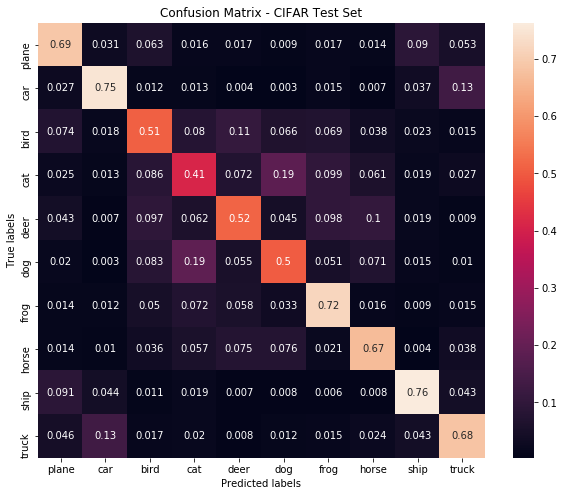

In [36]:
# CIFAR test set Confusion Matrix

y_preds = np.argmax(preds, axis=1)
y_true = cifar_labels
conf_mat = cm(y_true, y_preds, normalize='true')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - CIFAR Test Set')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

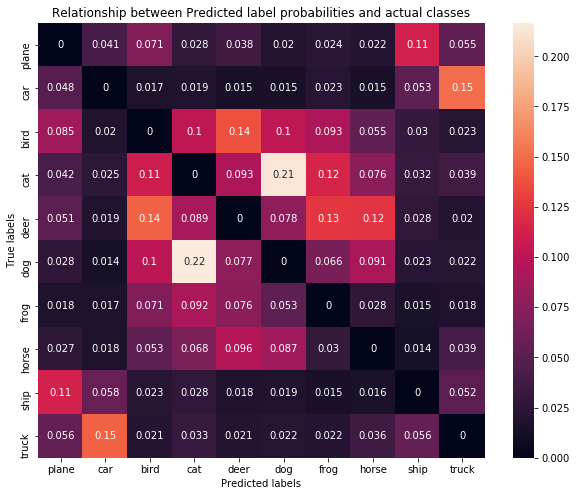

In [39]:
# Create conf-matrix like proba-distribution visualization for model labels
# Ground each model proba for an image on the ground truth and find the distribution for each GT class(rows)


pred_counts = np.unique(np.argmax(preds, axis=1), return_counts=True)[1]
# print(pred_counts)
pred_conf = np.zeros((10,10))
for i, prob in enumerate(preds):
    gt_label = cifar_labels[i]
    pred_conf[gt_label] += prob

for i, count in enumerate(pred_counts):
    pred_conf[i] /= count

# Diagonal elements set to zero so that other correlations are enhanced
pred_conf2 = np.zeros((10,10))
for i in range(len(pred_conf)):
    for j in range(len(pred_conf[0])):
        if i != j:
            pred_conf2[i][j] = pred_conf[i][j]
    
fig = plt.figure(figsize=(10,8))
  
ax = fig.add_subplot()
sns.heatmap(pred_conf2, annot=True, ax = ax); #annot=True to annotate cells  

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Relationship between Predicted label probabilities and actual classes')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

0.5358323137086862


[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

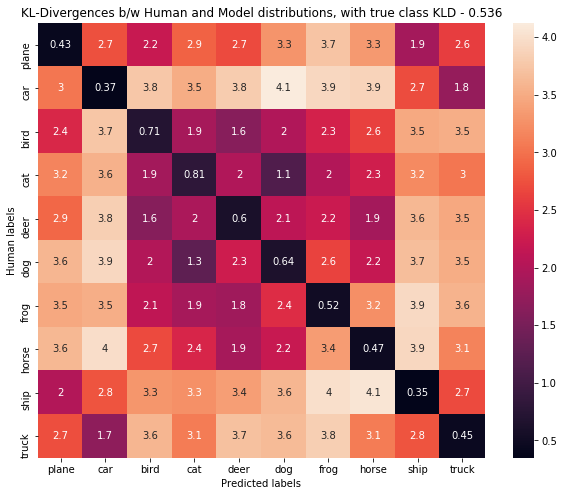

In [38]:
# KL Divergence plot between human labels and model labels
# Ideally, if a model is generalized well, KL Divergence between similar classes = low
# Relevant KLD is across proba distributions of the same class

def kl_div(actual, pred):
    return np.sum(np.where(actual != 0, actual * np.log(actual/pred), 0))

kldiv_matrix = np.zeros((10,10))
relevant_kld = 0
for i in range(len(human_conf)):
    for j in range(len(human_conf[0])):
        kldiv_matrix[i][j] = kl_div(human_conf[i], pred_conf[j])
        if i == j:
            relevant_kld += kldiv_matrix[i][j]
            
print(relevant_kld/10.0)
fig = plt.figure(figsize=(10,8))
  
ax = fig.add_subplot()
sns.heatmap(kldiv_matrix, annot=True, ax = ax); #annot=True to annotate cells  

ax.set_xlabel('Predicted labels')
ax.set_ylabel('Human labels')
ax.set_title('KL-Divergences b/w Human and Model distributions, with true class KLD - {}'.format(round(relevant_kld/10, 3)))
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)